In [1]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from gurobipy import *
from scipy.spatial.distance import cdist, euclidean
from scipy.stats import truncnorm
from scipy.sparse import csr_matrix
from time import time
import networkx as nx

#path = "C:/Users/a.rojasa55/OneDrive - Universidad de los Andes/Documentos/MOPTA-23/Data/"
path = "C:/Users/ari_r/OneDrive - Universidad de los Andes/Documentos/MOPTA-23/Data/"
vehicles = pd.read_csv(path+'MOPTA2023_car_locations.csv', sep = ',', header = None)

stations = pd.read_csv(path+"fuel_stations.csv")

northern = (-79.761960, 42.269385)
southern = (-76.9909,39.7198)
western = (-80.519400, 40.639400)
eastern = (-74.689603, 41.363559)

stations_loc = stations[["Longitude","Latitude"]]
stations_loc["Latitude"] = (stations["Latitude"]-southern[1])*69*165/178
stations_loc["Longitude"] = (stations["Longitude"]-western[0])*53

stations = stations_loc[(stations_loc["Longitude"] <= 290) & (stations_loc["Latitude"] <= 150)]
stations.rename(columns={"Longitude": 0, "Latitude":1}, inplace=True)

C:\Users\ari_r\AppData\Local\Temp\ipykernel_5032\3189103986.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations_loc["Latitude"] = (stations["Latitude"]-southern[1])*69*165/178
C:\Users\ari_r\AppData\Local\Temp\ipykernel_5032\3189103986.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations_loc["Longitude"] = (stations["Longitude"]-western[0])*53
C:\Users\ari_r\AppData\Local\Temp\ipykernel_5032\3189103986.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [8]:
def feasibility_vehic_to_locations(df_vehic,v,r, df_loc, steps_per_hour, driving_speed, charging_speed, T):
    distances = {s:euclidean((df_vehic.loc[v,0], df_vehic.loc[v,1]), (df_loc.loc[s,0], df_loc.loc[s,1])) for s in range(1,df_loc.shape[0]+1)}
    p = {s:250-(r-distances[s]) for s in range(1,df_loc.shape[0]+1)}
    a = {s:int(distances[s]*steps_per_hour/driving_speed)+1 for s in range(1,df_loc.shape[0]+1)}
    k = {s:int(p[s]*steps_per_hour/charging_speed)+1 for s in range(1,df_loc.shape[0]+1)}
    return sum([1 if r/distances[s] >= 1 and a[s]+k[s]-1<=T[-1] else 0 for s in range(1,df_loc.shape[0]+1)])


def distance_matrix(df1, df2):
    # Extract the x and y coordinates as arrays
    x1 = np.array(df1[0])
    y1 = np.array(df1[1])
    x2 = np.array(df2[0])
    y2 = np.array(df2[1])
    
    # Compute the pairwise distances between the two sets of points
    distances = cdist(np.column_stack((x1, y1)), np.column_stack((x2, y2)))
    
    # Convert the distance matrix to a dictionary
    distance_dict = {}
    for i in range(1,len(df1)+1):
        for j in range(1,len(df2)+1):
            location1 = i
            location2 = j
            distance = distances[i-1,j-1]
            distance_dict[(location1, location2)] = round(distance,2)
            
    return distance_dict

In [9]:
def get_graph_first(s,C,T,a,k,d,p,cd,cw,pi,sigma):

    def feas_B(n1,n2):
        return (n1[0] != n2[0]) and (n2[1] == max(n1[1]+1,a[n2[0],s])) and (a[n1[0],s] < a[n2[0],s]) and (n1[1]-a[n1[0],s]+1 >= k[n1[0],s]) and (n2[1]+k[n2[0],s]-1<=T[-1])

    Q = [(c,t) for c in C for t in T if t >= a[c,s]]
    V = {"s":((C[-1]+C[0])/2,0),"Q":Q,"e":((C[-1]+C[0])/2,T[-1]+1)}

    D = [(V["s"],n) for n in Q if n[1] == a[n[0],s]]
    W = [(n1,n2) for n1 in Q for n2 in Q if n1[0] == n2[0] and n2[1] == n1[1]+1]
    B = [(n1,n2) for n1 in Q for n2 in Q if feas_B(n1,n2)]
    E = [(n,V["e"]) for n in Q if n[1]-a[n[0],s]+1>=k[n[0],s]]

    A = {"D":D,"W":W,"B":B,"E":E}

    rc = {(i,j):cd*d[j[0],s]-pi[f"V{j[0]}"]-sigma for (i,j) in A["D"]}
    rc.update({(i,j):cw*p[i[0],s]/k[i[0],s] for (i,j) in A["W"]})
    rc.update({(i,j):cw*p[i[0],s]/k[i[0],s]+cd*d[j[0],s]-pi[f"V{j[0]}"] for (i,j) in A["B"]})
    rc.update({(i,j):cw*p[i[0],s]/k[i[0],s] for (i,j) in A["E"]})

    return V,A,rc

def vertices_extensions_first(V,A):
    V = [V["s"]] + V["Q"] + [V["e"]]
    A = A["D"] + A["B"] + A["W"] + A["E"]
    G = nx.DiGraph()
    G.add_nodes_from(V); G.add_edges_from(A)
    outbound_arcs = {}
    for v in V:
        outbound_arcs[v] = list(G.out_edges(v))
        
    return outbound_arcs

def label_algorithm_first(s,V,A,C,T,r,k,a,ext,pi,sigma):

    def label_extension(l,arc):
        for m in range(1):
            i = arc[0]; j = arc[1]
            new_label = [[], 0, 0, {}, True]

            ''' Check whether the extension is feasible '''
            if (arc in A["B"] or arc in A["E"]) and l[2] > 1: break
            elif arc in A["W"] and l[2] == 1: break

            ''' Update waiting line resource and check feasibility '''
            new_label[3].update(l[3])
            feas = True
            if arc in A["B"]:
                for t in range(a[j[0],s],i[1]+1):
                    new_label[3][t] += 1
                    if new_label[3][t] > 1: feas = False; break
            if not feas: break
            
            ''' Update the resources consumption '''
            new_label[0] += l[0] + [j]
            new_label[1] += l[1] + r[(i,j)]

            if arc in A["W"] or arc in A["E"]: new_label[2] =  l[2] - 1
            else: new_label[2] = k[j[0],s]
            
            if j == V["e"]: done.append(new_label)
            else: labels.append(new_label)

    
    ''' Labels list '''
    # Index: number of label
    # 0: route
    # 1: cumulative reduced cost
    # 2: number of timesteps until full recharge
    # 3: number of vehicles waiting in line at timestep t
    labels = []; done = []
    for arc in ext[V["s"]]:
        labels.append( [[arc[0], arc[1]], r[arc], k[arc[1][0],s], {t:0 for t in T}] )

    while len(labels) > 0:
        
        L = range(len(labels))
        for l in L:
            for arc in ext[labels[l][0][-1]]:
                label_extension(labels[l], arc)

        del labels[:len(L)]
    
    routes = []
    for l in range(len(done)):
        # If reduced cost is negative
        if done[l][1] < -0.001:
            veh = set()
            for n in done[l][0][1:len(done[l][0])-1]:
                veh.add(n[0])
            col = {c:1 if c in veh else 0 for c in C}
            routes.append((col,done[l][1]+sum(pi[f"V{c}"]*col[c] for c in C)+sigma))

    return routes

In [10]:
def chorizo_maker(S,C,S_c,C_s,T,cd,cw,d,p):

    routes = {0:[]}
    for c in C:
        routes[0].append(({cc:1 if cc == c else 0 for cc in C},250*(cd+cw)))

    np.random.seed(0)
    for s in S:
        rand = np.random.choice(C_s[s])
        routes[s] = [({c:1 if c == rand else 0 for c in C_s[s]},cd*d[rand,s]+cw*p[rand,s])]

    return routes

def master_problem(S,C,y,routes,S_c,C_s,output=0,write=0,integer=0):

    R = {s:range(len(routes[s])) for s in S+[0]}

    f_r = {s:{r:routes[s][r][1] for r in R[s]} for s in S+[0]}
    z_r = {s:{r:routes[s][r][0] for r in R[s]} for s in S+[0]}

    m = Model("Restricted Master Problem")

    if integer == 1: nat = GRB.BINARY
    else: nat = GRB.CONTINUOUS

    lbd = {s:{r:m.addVar(name=f"lambda_{s,r}",vtype=nat) for r in R[s]} for s in S+[0]}

    for c in C:
        m.addConstr(quicksum(z_r[s][r][c]*lbd[s][r] for s in S_c[c]+[0] for r in R[s]) >= 1, f"V{c}_assignment")

    for s in S:
        m.addConstr(quicksum(lbd[s][r] for r in R[s]) <= y[s], f"S{s}_convexity")
    
    m.setObjective(quicksum(f_r[s][r]*lbd[s][r] for s in S+[0] for r in R[s]))

    m.update()
    m.setParam("OutputFlag",output)
    m.optimize()

    z = {(c,s):sum(z_r[s][r][c]*lbd[s][r].X for r in R[s]) for s in S for c in C_s[s]}
    infeasible = [c for c in C if sum(z_r[0][r][c]*lbd[0][r].X for r in R[0]) > 0]

    pi_0 = {}
    if integer == 0:
        for c in C:
            cons = m.getConstrByName(f"V{c}_assignment")
            pi_0[f"V{c}"] = cons.getAttr("Pi")
        for s in S:
            cons = m.getConstrByName(f"S{s}_convexity")
            pi_0[f"S{s}"] = cons.getAttr("Pi")
    
    if write:
        A = m.getA()
        denseMatrix = pd.DataFrame(data=csr_matrix.todense(A))
        denseMatrix.to_csv("./Amatrix_MP.csv", index=False)

    return pi_0,infeasible,m.getObjective().getValue(),z

def second_stage_SPP(S,C,T,y,a,d,r,p,k,cd,cw):

    def feas(v,s):
        return d[v,s]<=r[v] and a[v,s]+k[v,s]-1<=T[-1] and a[v,s]<=T[-1]
    
    optimal = False; i = 0

    S_c = {c:[s for s in S if feas(c,s)] for c in C}
    C_s = {s:[c for c in C if feas(c,s)] for s in S}
    routes = chorizo_maker(S,C,S_c,C_s,T,cd,cw,d,p)

    objs = []; exist = len(routes[1])
    time0 = time()

    while True:
        i += 1

        pi, infeasible, objMP,zz = master_problem(S,C,y,routes,S_c,C_s,output=0)
        print(f"Iteration {i}:\n{len(infeasible)} vehicles\tMP obj: {round(objMP,2)}\ttime: {round(time()-time0,2)}s")

        if sum([1 for k in C if pi[f"V{k}"]<0]) == 0: break

        opt = {}
        for s in S:
            V,A,rc = get_graph_first(s,C_s[s],T,a,k,d,p,cd,cw,pi,pi[f"S{s}"])
            ext = vertices_extensions_first(V,A)
            opt[s] = label_algorithm_first(s,V,A,C_s[s],T,rc,k,a,ext,pi,pi[f"S{s}"])
            print(f"Station {s}: {len(opt[s])} new columns")
            routes[s] += opt[s]

        objs.append(objMP)
    
    pi, infeasible, objMP, zz = master_problem(S,C,y,routes,S_c,C_s,output=0,integer=1)

    return infeasible, objMP, zz, objs

In [11]:
''' Number of vehicles and stations '''

C = list(range(1,101))
S = list(range(1,11))

''' Fixed parameters '''

driving_speed = 75 # miles per hour
steps_per_hour = 6 # each time step is ten minutes
charging_speed = 75*12/7 # miles per hour
T = list(range(1,int(steps_per_hour*2.5)+1)) # Planning horizon

loc, scale, min_v, max_v= 100, 50, 20, 250
a, b = (min_v - loc) / scale, (max_v - loc) / scale

''' Feasible instance generator '''

d = distance_matrix(vehicles,stations)

random.seed(453)
''' Feasible instance creation '''
feas_long = 145; feas_lat = 75

stations = stations[(stations[0] >= feas_long) & (stations[1] <= feas_lat)]
stations.index = np.arange(1, len(stations) + 1)
indices = random.sample(range(len(stations)), len(S))
stations = stations.iloc[indices]
stations.index = np.arange(1, len(stations) + 1)

vehicles = vehicles[(vehicles[0] >= feas_long) & (vehicles[1] <= feas_lat)]
vehicles.index = np.arange(1, len(vehicles) + 1)

feasible = 0; sample_vehic = pd.DataFrame({0:[], 1:[], "range":[]})
while feasible < len(C):
    index = random.randint(1,vehicles.shape[0]-1)
    range_real = truncnorm.rvs(a = a, b = b, loc = loc, scale = scale, size = 1)

    if feasibility_vehic_to_locations(vehicles, index, range_real, stations, steps_per_hour, driving_speed, charging_speed, T) >= len(S):
        feasible += 1
        sample_vehic = pd.concat([sample_vehic,pd.DataFrame({0:vehicles.loc[index,0], 1:vehicles.loc[index,1], "range":[range_real]},index=[0])])
        sample_vehic.index = np.arange(1, len(sample_vehic) + 1)

d = distance_matrix(sample_vehic,stations)
r = {c:sample_vehic.loc[c,"range"][0] for c in C}
p = {(c,s):250-(r[c]-d[c,s]) for c in C for s in S}
a = {(c,s):int(d[c,s]*steps_per_hour/driving_speed)+1 for c in C for s in S}
k = {(c,s):int(p[c,s]*steps_per_hour/charging_speed)+1 for c in C for s in S}
y = {s:6 for s in S}
cf = 5500
cd = 0.041
cw = 0.0388

In [6]:
infeasibleSPP1, objMP1, zz1, objs1 = second_stage_SPP(S,C,T,y,a,d,r,p,k,cd,cw)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-08
Iteration 1:
91 vehicles	MP obj: 1868.6	time: 0.13s
Station 1: 962 new columns
Station 2: 8469 new columns
Station 3: 3482 new columns
Station 4: 3698 new columns
Station 5: 9616 new columns
Station 6: 10495 new columns
Station 7: 6742 new columns
Station 8: 3839 new columns
Station 9: 15212 new columns
Station 10: 11172 new columns
Iteration 2:
0 vehicles	MP obj: 449.21	time: 906.37s
Station 1: 0 new columns
Station 2: 0 new columns
Station 3: 0 new columns
Station 4: 0 new columns
Station 5: 0 new columns
Station 6: 0 new columns
Station 7: 0 new columns
Station 8: 0 new columns
Station 9: 0 new columns
Station 10: 0 new columns


In [12]:
def get_graph(s,K,cd,cw,a,d,p,pi,sigma):

    V = ["s"] + K + ["e"]
    A = [(i,j) for i in V for j in V if i!=j and i!="e" and j!="s" and a[i,s] < a[j,s] and (i,j)!=("s","e")]

    rc = {arc:cd*d[arc[1],s]+cw*p[arc[1],s]-pi[f"V{arc[1]}"]-sigma if arc[0]=="s" else (0 if arc[1]=="e" else cd*d[arc[1],s]+cw*p[arc[1],s]-pi[f"V{arc[1]}"]) for arc in A}
    
    return V,A,rc


def vertices_extensions(V,A):
    
    G = nx.DiGraph()
    G.add_nodes_from(V); G.add_edges_from(A)
    outbound_arcs = {}
    for v in V:
        outbound_arcs[v] = list(G.out_edges(v))
    
    return outbound_arcs

def label_algorithm(s,V,K,T,r,t,a,ext,pi,sigma):

    def label_extension(l,arc):
        for m in range(1):
            i = arc[0]; j = arc[1]
            new_label = [[], 0, 0, 0]

            ''' Check waiting line feasibility '''
            if a[j,s] < l[2]: break
            if a[j,s] > l[3]: new_label[2] = l[2]
            else: new_label[2] = l[3]

            ''' Check time consumption feasibility '''
            new_label[3] = l[3] + max(0,a[j,s]-l[3]) + t[j,s]
            if new_label[3] > T: break
            
            ''' Update the resources consumption '''
            new_label[0] += l[0] + [j]
            new_label[1] = l[1] + r[(i,j)]
            
            if j == "e": done.append(new_label)
            else: labels.append(new_label)
    
    ''' Labels list '''
    # Index: number of label
    # 0: route
    # 1: cumulative reduced cost
    # 2: last moment where there was a vehicle waiting in line to use the charger
    # 3: cumulative time consumption
    labels = [ [[arc[0], arc[1]], r[arc], 0, a[arc[1],s]] for arc in ext["s"]]
    done = []

    while len(labels) > 0:
        
        L = range(len(labels))
        for l in L:
            for arc in ext[labels[l][0][-1]]:
                label_extension(labels[l], arc)

        del labels[:len(L)]
    
    routes = []
    for l in range(len(done)):
        # If reduced cost is negative
        if done[l][1] < -25:
            col = {k:1 if k in done[l][0] else 0 for k in K}
            routes.append((col,done[l][1]+sum(pi[f"V{k}"]*col[k] for k in K)+sigma))

    return routes

In [13]:
def chorizo_maker_new(S,K,K_s,cd,cw,d,p):

    routes = {0:[]}
    for k in K:
        routes[0].append(({kk:1 if kk == k else 0 for kk in K},250*(cd+cw)))

    np.random.seed(0)
    for s in S:
        rand = np.random.choice(K_s[s])
        routes[s] = [({k:1 if k == rand else 0 for k in K_s[s]},cd*d[rand,s]+cw*p[rand,s])]

    return routes

def second_stage_ESPP(S,K,T,y,a,d,r,p,t,cd,cw):

    def feas(v,s):
        return d[v,s]<=r[v] and a[v,s]+t[v,s]<=T
    
    i = 0

    S_k = {k:[s for s in S if feas(k,s)] for k in K}
    K_s = {s:[k for k in K if feas(k,s)] for s in S}
    routes = chorizo_maker_new(S,K,K_s,cd,cw,d,p)

    objs = []
    time0 = time()

    while True:
        i += 1

        pi, infeasible, objMP,zz = master_problem(S,K,y,routes,S_k,K_s,output=0)
        print(f"Iteration {i}:\n{len(infeasible)} vehicles\tMP obj: {round(objMP,2)}\ttime: {round(time()-time0,2)}s")

        objs.append(objMP)
        if sum([1 for k in K if pi[f"V{k}"]<0]): break

        opt = {}
        for s in S:
            V,A,rc = get_graph(s,K_s[s],cd,cw,a,d,p,pi,pi[f"S{s}"])
            ext = vertices_extensions(V,A)
            opt[s] = label_algorithm(s,V,K,T,rc,t,a,ext,pi,pi[f"S{s}"])
            print(f"Station {s}: {len(opt[s])} new columns")
            routes[s] += opt[s]

        if sum(len(opt[s]) for s in S) == 0: break
    
    pi, infeasible, objMP, zz = master_problem(S,K,y,routes,S_k,K_s,output=0,integer=1)

    return infeasible, objMP, zz, objs

In [47]:
def plot_graph(s,K,V,A,a,t,Route=None,color_arcs=False,feas=True):

    fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(16,len(V)-2))

    if color_arcs: col="#D60093"
    else: col="darkgray"
    for arc in A:
        if arc[0] == "s": ax1.plot([a[arc[0],s],a[arc[1],s]],[(V[-2]+V[1])/2,arc[1]],linestyle="-",color=col,marker=None)
        elif arc[1] == "e": ax1.plot([a[arc[0],s],a[arc[1],s]],[arc[0],(V[-2]+V[1])/2],linestyle="-",color=col,marker=None)
        else: ax1.plot([a[arc[0],s],a[arc[1],s]],[arc[0],arc[1]],linestyle="-",color=col,marker=None)

    ''' Charging route '''
    if Route is not None:
        if feas: col = "limegreen"
        else: col = "firebrick"
        ax1.plot([a["s",s],a[Route[0],s]],[(V[-2]+V[1])/2,Route[0]],linestyle="-",color=col,marker=None)
        for i in range(len(Route)-1):
            ax1.plot([a[Route[i],s],a[Route[i+1],s]],[Route[i],Route[i+1]],linestyle="-",color=col,marker=None)
        ax1.plot([a[Route[-1],s],a["e",s]],[Route[-1],(V[-2]+V[1])/2],linestyle="-",color=col,marker=None)
    
    ''' Vehicle nodes '''
    for v in V:
        if v in ["s","e"]: ax1.plot(a[v,s],(V[-2]+V[1])/2,marker="o",markersize=18,color="forestgreen")
        else: ax1.plot(a[v,s],v,marker="o",markersize=18,color="navy")

    ax1.set_xlim(-0.05,T+0.05); ax1.set_xlabel("Time (minutes)",fontsize=14)
    ax1.set_ylim(0.5,len(V)-2+0.5); ax1.set_ylabel("Vehicles",fontsize=14)

    timesteps = [t*T/10 for t in range(11)]
    ax1.set_xticks(timesteps); ax1.set_xticklabels([int(t*60) for t in timesteps],fontsize=14)

    ax1.set_yticks(K); ax1.set_yticklabels([f"k{k}" for k in K], fontsize=14)

    ax1.invert_yaxis()
    ax1.grid(which="minor",axis="x")

    cum_t = 0; i = 1
    for k in Route:
        if cum_t > a[k,s]: ax2.barh(y=i,width=cum_t-a[k,s],height=1,left=a[k,s],color="turquoise")
        ax2.barh(y=i,width=t[k,s],height=1,left=cum_t+max(0,a[k,s]-cum_t),color="forestgreen")
        cum_t += max(0,a[k,s]-cum_t) + t[k,s]; i+=1

    ax2.set_xlim(-0.05,T+0.05)

    timesteps = [t*T/10 for t in range(11)]
    ax2.set_xticks(timesteps); ax2.set_xticklabels([int(t*60) for t in timesteps],fontsize=14)
    ax2.set_yticks([k for k in range(1,i)]); ax2.set_yticklabels([f"k{k}" for k in Route],fontsize=14)

    ax2.set_xlabel("Time (minutes)",fontsize=14)
    ax2.set_ylabel("Vehicles",fontsize=14)

    ax2.invert_yaxis()

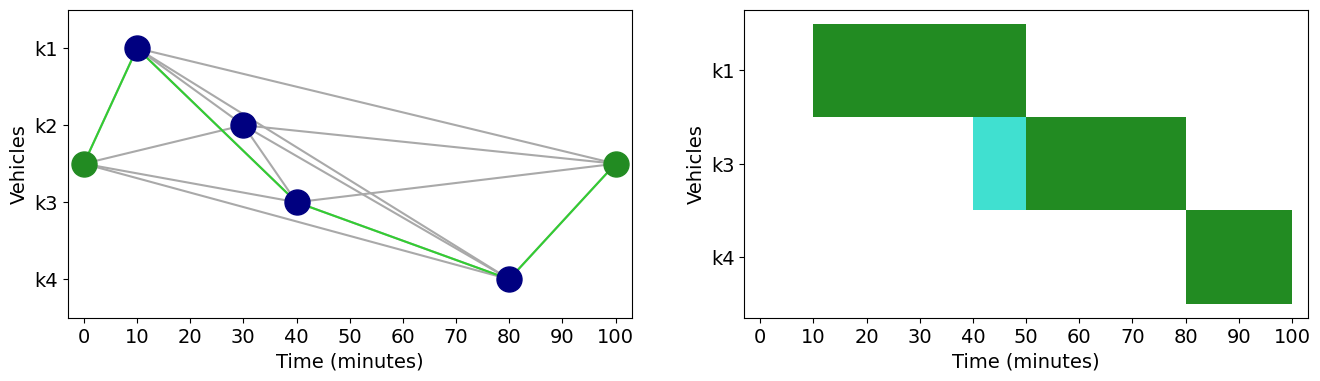

In [52]:
cd = 0.041
cw = 0.0388

K = list(range(1,5))
T = 100/60
a = {("s",1):0, (1,1):10/60, (2,1):30/60, (3,1):40/60, (4,1):80/60, ("e",1):T}
t = {("s",1):0, (1,1):40/60, (2,1):30/60, (3,1):30/60, (4,1):20/60, ("e",1):0}
V,A,rc = get_graph(1,K,cd,cw,a,d,p,{f"V{k}":0 for k in K},0)
plot_graph(1,K,V,A,a,t,Route=[1,3,4])

In [9]:
K = C
T = 2.5
t = {(k,s):p[k,s]/charging_speed for k in K for s in S}
a = {(k,s):d[k,s]/driving_speed for k in K for s in S}
a.update({("s",s):0 for s in S})
a.update({("e",s):T for s in S})
t.update({("e",s):0 for s in S})

In [13]:
infeasibleSPP2, objMP2, zz2, obj2 = second_stage_ESPP(S,K,T,y,a,d,r,p,t,cd,cw)

Iteration 1:
90 vehicles	MP obj: 1851.86	time: 0.09s
Station 1: 2406 new columns
Station 2: 199539 new columns
Station 3: 14436 new columns
Station 4: 47453 new columns
Station 5: 107317 new columns
Station 6: 66568 new columns
Station 7: 124208 new columns
Station 8: 55323 new columns
Station 9: 106142 new columns
Station 10: 88634 new columns
Iteration 2:
0 vehicles	MP obj: 471.59	time: 743.65s
Station 1: 0 new columns
Station 2: 0 new columns
Station 3: 0 new columns
Station 4: 0 new columns
Station 5: 0 new columns
Station 6: 0 new columns
Station 7: 0 new columns
Station 8: 0 new columns
Station 9: 0 new columns
Station 10: 0 new columns


KeyboardInterrupt: 